In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from models.model_fpgan import FPGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [23]:
# tem 3 classes, n usar para ja
data = pd.read_csv("D:/Datasets/breast/data.csv")
data = data.drop(columns=['Unnamed: 32'])
data = data.drop(columns=['id'])
data.loc[data["diagnosis"] == 'M' , "diagnosis"] = 0
data.loc[data["diagnosis"] == 'B' , "diagnosis"] = 1
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [24]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0.0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.70314,0.731113,0.686364,...,0.620776,0.141525,0.66831,0.450698,0.601136,0.619292,0.56861,0.912027,0.598462,0.418864
1,0.0,0.643144,0.272574,0.615783,0.501591,0.28988,0.181768,0.203608,0.348757,0.379798,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.23359,0.222878
2,0.0,0.601496,0.39026,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,...,0.556386,0.360075,0.508442,0.374508,0.48359,0.385375,0.359744,0.835052,0.403706,0.213433
3,0.0,0.21009,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,...,0.24831,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.88488,1.0,0.773711
4,0.0,0.629893,0.156578,0.630986,0.48929,0.430351,0.347893,0.463918,0.51839,0.378283,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.1575,0.142595


In [25]:
target = 'diagnosis'

In [26]:
X = data.drop(columns=[target])
y = data[target]
y=y.astype('int')

In [27]:
model_ctgan = FPGANSynthesizer(epochs=2000)
original_losses, tranformed_privacies, losses = model_ctgan.fit(data)

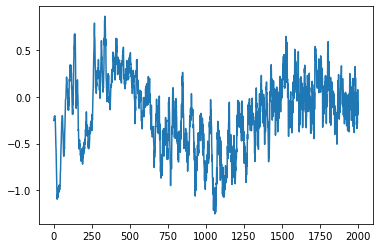

In [28]:
plt.plot(losses)
plt.show()

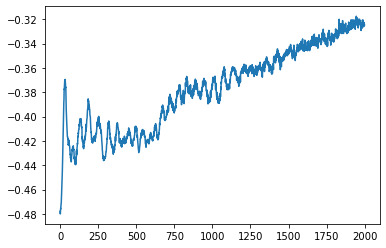

In [29]:
plt.plot(tranformed_privacies)
plt.show()

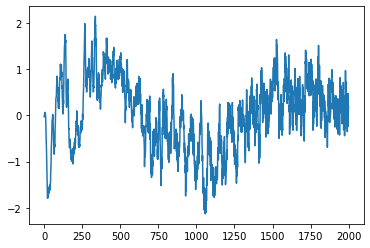

In [30]:
plt.plot(original_losses)
plt.show()

In [31]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [32]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame

In [33]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.14854215]


In [34]:
samples.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.025821,0.359820,0.442993,0.253590,0.045205,0.464523,0.209167,0.004324,0.021152,0.402823,...,0.107244,0.936047,0.278323,0.094526,0.331587,0.233264,0.129445,0.091989,0.427920,0.088148
1,1.027111,0.143768,0.090154,0.098491,0.146489,0.366387,0.164399,-0.023565,0.013563,0.273903,...,0.351840,0.847834,0.050142,0.067639,0.099819,0.103049,0.015292,-0.074778,0.319290,0.079637
2,-0.021418,0.615100,0.391486,0.524620,0.277828,0.401133,0.675525,0.518877,0.095512,0.476402,...,0.781987,0.721004,0.787229,0.943917,0.449610,0.396698,0.424147,0.330377,0.245635,0.161954
3,0.963427,0.725395,0.136606,0.125665,0.272007,0.393944,0.658580,0.513919,0.293040,0.284335,...,0.876488,0.560288,0.515383,0.277343,0.346433,0.237980,0.679355,0.719201,0.326982,0.080598
4,0.994983,0.231958,0.699707,0.467472,0.083239,0.425017,0.273622,0.040961,0.120588,0.388918,...,0.275112,0.509256,0.026069,0.055786,0.363265,0.053967,0.178140,0.121911,0.361988,0.191244


## Fidelity

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = True)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = True)

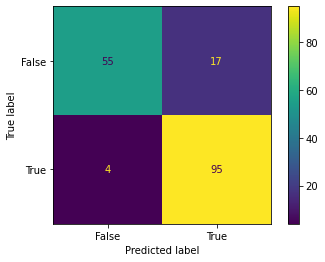

In [36]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [45]:
percentage, same_pred, dif_pred = eval_fidelity(rr_pred, fr_pred)

0 1


In [46]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.935672514619883
Accuracy of synthetic data:  0.8830409356725146


In [47]:
print(same_pred, dif_pred)

0.7236842105263158 0.8189655172413793


## Final plot

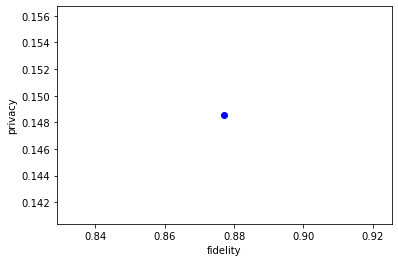

In [48]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()